In [1]:
import os
import json
import numpy as np
import laspy as lp
import pyvista as pv
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

def get_las_file_paths(root_dir):
    las_file_paths = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.las'):
                las_file_paths.append(os.path.join(root, file))
    return las_file_paths

def view_cloud_pv(points):
    xyz = points[:, :3]  # Primeras 3 columnas: X, Y, Z
    rgb = points[:, 3:6]  # Columnas 4-6: R, G, B
    
    # Normalizar RGB de 16-bit (LAS) a 8-bit (0-255)
    if np.issubdtype(rgb.dtype, np.integer) and rgb.max() > 255:
        rgb = (rgb // 256).astype(np.uint8)  # Conversión a 8-bit
    
    # Crear objeto PolyData con coordenadas
    cloud = pv.PolyData(xyz)
    
    # Añadir colores RGB como array asociado a los puntos
    cloud["RGB"] = rgb.astype(np.uint8)  # Asegurar tipo uint8
    
    # Configurar plotter
    plotter = pv.Plotter()
    plotter.add_mesh(
        cloud,
        scalars="RGB",  # Usar el array RGB
        rgb=True,       # Indicar que son canales RGB
        point_size=3,   # Tamaño de los puntos
        opacity=1       # Opacidad total
    )
    
    plotter.show()

def get_points(path):
    las = lp.read(path)
    points = np.vstack((las.x, las.y, las.z)).transpose()
    rgb = np.vstack((las.red, las.green, las.blue)).transpose()
    data_points = np.hstack((
        points,
        rgb,
        np.expand_dims(las.return_number, -1),
        np.expand_dims(las.number_of_returns, -1)
    ))

    single = data_points[data_points[:, -1] == 1][:, :6]  #XYZRGB
    return single

def get_roi(points, p=0.05):
    # Obtener límites originales
    x_min = np.min(points[:, 0])
    x_max = np.max(points[:, 0])
    y_min = np.min(points[:, 1])
    y_max = np.max(points[:, 1])
    
    # Calcular 5% del largo de cada eje
    x_offset = p * (x_max - x_min)
    y_offset = p * (y_max - y_min)
    
    # Ajustar límites hacia adentro
    new_x_min = x_min + x_offset
    new_x_max = x_max - x_offset
    new_y_min = y_min + y_offset
    new_y_max = y_max - y_offset
    
    return new_x_min, new_x_max, new_y_min, new_y_max

def bresenham_line(start=(10, 10), end=(10, 60)):
    # Unpack start and end points
    x1, y1 = np.array(start, dtype=np.int32).copy()
    x2, y2 = np.array(end, dtype=np.int32).copy()


    # Calculate differences
    dx = x2 - x1
    dy = y2 - y1

    # Determine if the line is steep (more vertical than horizontal)
    is_steep = abs(dy) > abs(dx)

    # Swap coordinates if the line is steep (for easier handling)
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Ensure the line is always drawn left-to-right
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1

    # Recalculate differences after the possible swap
    dx = x2 - x1
    dy = y2 - y1

    # Error term initialized to half of dx
    error = dx // 2
    ystep = 1 if y1 < y2 else -1  # Determines whether to increment or decrement y

    # List to store the generated points
    points = []
    y = y1

    # Main loop for Bresenham's algorithm
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)  # Swap x and y if the line is steep
        points.append(coord)

        # Update error term
        error -= abs(dy)

        # If error is negative, adjust y and reset the error term
        if error < 0:
            y += ystep
            error += dx

    return points

In [2]:
import laspy as lp
import numpy as np
import matplotlib.pyplot as plt
import glob

# pozas a analizar
# 05-04-2025, PAM4:6, RBN, RBS, 1B, 2B, 3B  (100-150m_10ms_100khz, 150m_7ms_100khz)
# 06-04-2025, 6B,7B,8B (100-150m_10ms_100khz)
# 07-04-2025 9D,9E,9F (07-04-25 100m&150m 100Khz 10ms)
# 20-05-2025 7H-7I (250520_164647_7H-7I)

pozas = {
    "05-04-2025": [
        (558911.202,	7395022.839,	2302.254),
        (559066.708,	7395213.229,	2302.312),
        (559426.535,	7395214.473,	2302.104),
        (559424.764,	7394923.6,	    2302.141),
        (559086.394,	7394922.151,	2302.548)
    ],
    "06-04-2025": [
        (560911.613,	7394924.804,	2302.257),
        (560890.692,	7395213.724,	2302.17),
        (560226.493,	7395213.41,	    2302.125),
        (560272.775,	7394923.702,	2302.166)
    ],
    "07-04-2025": [
        (560017.361,	7396867.478,	2302.276),
        (560337.286,	7396821.869,	2302.183),
        (560336.371,	7397452.667,	2302.161),
        (560014.374,	7397467.77,	    2302.101)
    ],
    "20-05-2025": [
        (559312.555,	7397597.671,	2302.237),
        (559191.918,	7397634.896,	2300.614),
        (559181.084,	7397829.565,	2300.549),
        (559404.816,	7397855.527,	2300.577),
        (559420.061,	7397653.057,	2300.549),
        (559401.47,	    7397565.702,	2301.48),
        (559436.115,	7397321.4,	    2301.522),
        (559167.14,	    7397328.512,	2301.265),
        (559163.896,	7397558.826,	2301.331)
    ]
}

In [3]:
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd

def find_best_gmm(data, max_components=2, criterion='aic', **kwargs):
    '''
    Find the best number of components for a Gaussian Mixture Model using AIC or BIC. 
    '''

    n_components_range = range(1, max_components + 1)
    criterions, means = [], []

    if criterion not in ['aic', 'bic']:
        raise ValueError("Invalid criterion. Use 'bic' or 'aic'.")

    for n in n_components_range:
        try:
            gmm = GaussianMixture(n_components=n, **kwargs)
            gmm.fit(data)
            if criterion == 'bic':
                criterions.append(gmm.bic(data))
            else:
                criterions.append(gmm.aic(data))
            means.append(gmm.means_)
        except ValueError as e:
            print(f"Error fitting GMM with {n} components: {e}")
            break

    return n_components_range[np.argmin(criterions)], means[np.argmin(criterions)]


In [4]:
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator

def generate_dem(points, rasante, x_interest, y_interest):
    # Extraer y procesar coordenadas
    x, y, z = points[:, 0], points[:, 1], points[:, 2] - rasante
    #z = np.clip(z,0, 4)
    
    grid_spacing = np.mean(np.sqrt(np.diff(x)**2 + np.diff(y)**2)) * 2
    
    # Crear dimensiones de la grilla
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    
    cols = int(np.ceil((x_max - x_min) / grid_spacing))
    rows = int(np.ceil((y_max - y_min) / grid_spacing))

    # Binning para promedio de elevaciones
    grid_sum = np.zeros((rows, cols))
    grid_count = np.zeros((rows, cols))
    
    xi = ((x - x_min) / grid_spacing).astype(int)
    yi = ((y_max - y) / grid_spacing).astype(int)

    new_x_interest = ((x_interest - x_min) / grid_spacing).astype(int)
    new_y_interest = ((y_max - y_interest) / grid_spacing).astype(int)
    
    np.add.at(grid_sum, (yi, xi), z)
    np.add.at(grid_count, (yi, xi), 1)
    
    dem = np.divide(grid_sum, grid_count, where=grid_count != 0)
    dem[grid_count == 0] = np.nan
    
    # --- Interpolación combinada lineal + nearest ---
    mask = ~np.isnan(dem)
    y_coords, x_coords = np.where(mask)

    xx = x_min + (x_coords + 0.5) * grid_spacing
    yy = y_max - (y_coords + 0.5) * grid_spacing

    # Primera interpolación: Lineal
    linear_interp = LinearNDInterpolator(list(zip(xx, yy)), dem[mask])

    grid_x, grid_y = np.meshgrid(
        x_min + (np.arange(cols) + 0.5) * grid_spacing,
        y_max - (np.arange(rows) + 0.5) * grid_spacing
    )

    dem_filled = dem.copy()
    nan_mask = np.isnan(dem)
    dem_filled[nan_mask] = linear_interp(grid_x[nan_mask], grid_y[nan_mask])

    # Segunda interpolación: Nearest para NaN residuales
    if np.isnan(dem_filled).any():
        print("Aplicando Nearest para NaN residuales")
        nearest_interp = NearestNDInterpolator(list(zip(xx, yy)), dem[mask])
        residual_nan = np.isnan(dem_filled)
        dem_filled[residual_nan] = nearest_interp(grid_x[residual_nan], grid_y[residual_nan])

    return dem_filled, new_x_interest, new_y_interest

In [9]:
dates = list(pozas.keys())[3:]
print(dates)

['20-05-2025']


Date: 20-05-2025
Condition:  /home/diego/Downloads/data_sqm/Vuelos_20-05-2025/250520_164647_7H-7I
Condition-LAS:  /home/diego/Downloads/data_sqm/Vuelos_20-05-2025/250520_164647_7H-7I/7-i_100m_7ms_100khz_plena-luz_0_0_poza.las
Cota sal SQM: 2302.237
Cota sal promedio original: 2302.5598809794988
Aplicando Nearest para NaN residuales


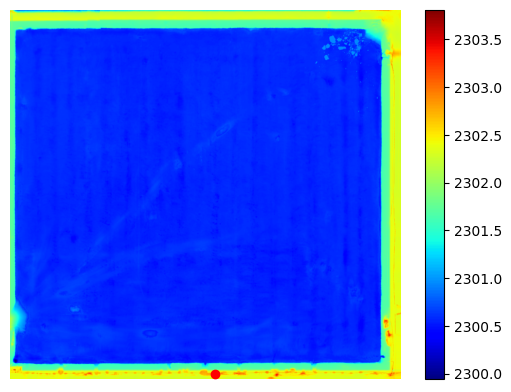

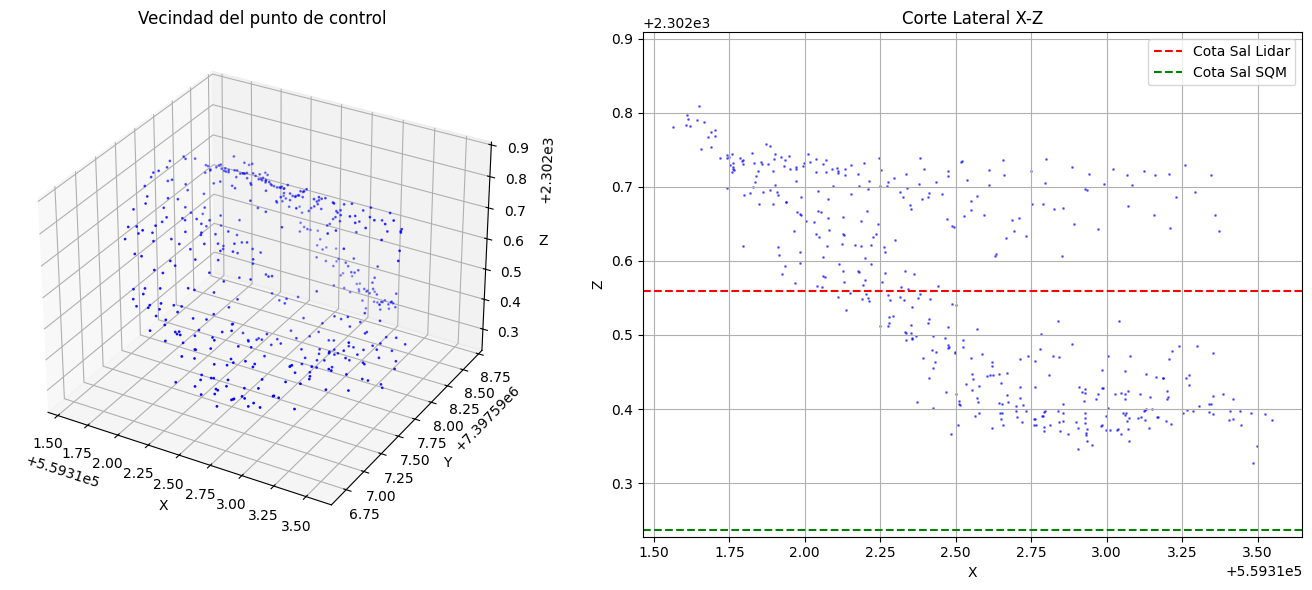

Z del punto más cercano al punto de interés: 2302.3737499999997 Distancia: 0.06639747732944769
Cota sal promedio con error mínimo: 2302.3275 Distancia: 0.9298497189968643

Cota sal SQM: 2300.614
Cota sal promedio original: 2300.6173579545457
Aplicando Nearest para NaN residuales


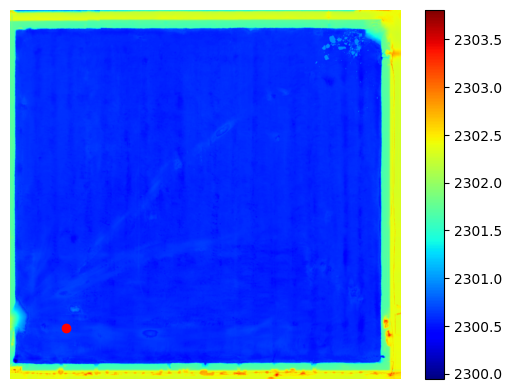

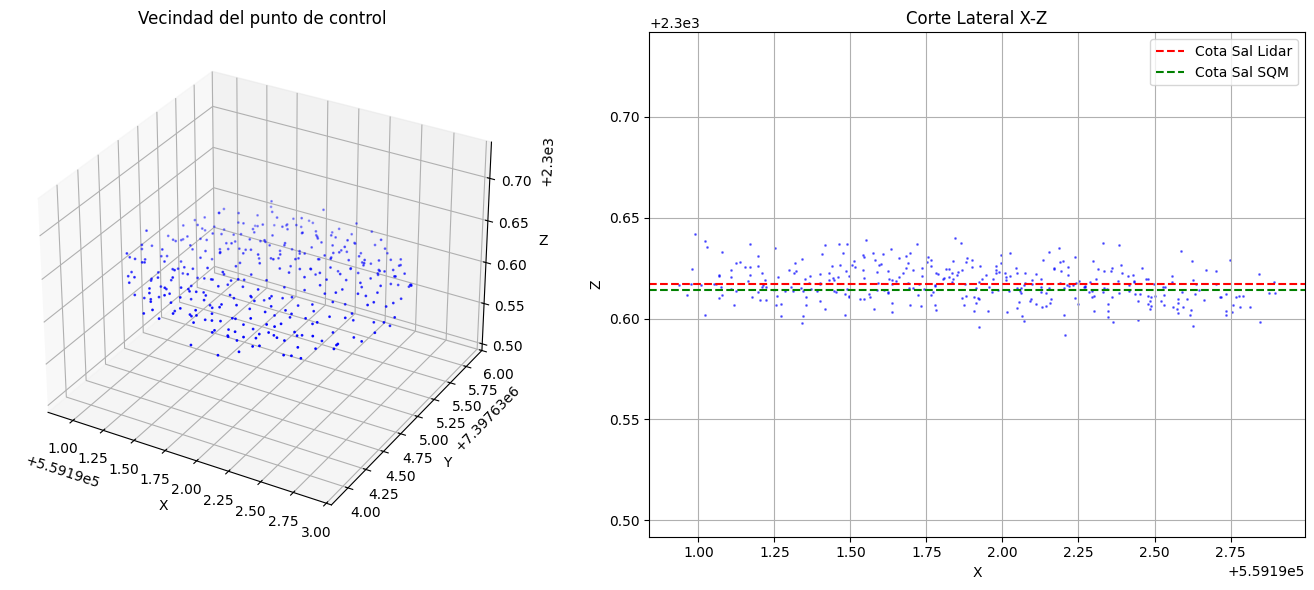

Z del punto más cercano al punto de interés: 2300.596 Distancia: 0.08482224005384183
Cota sal promedio con error mínimo: 2300.614 Distancia: 0.7193143003424088

Cota sal SQM: 2300.549
Cota sal promedio original: 2300.577365866388
Aplicando Nearest para NaN residuales


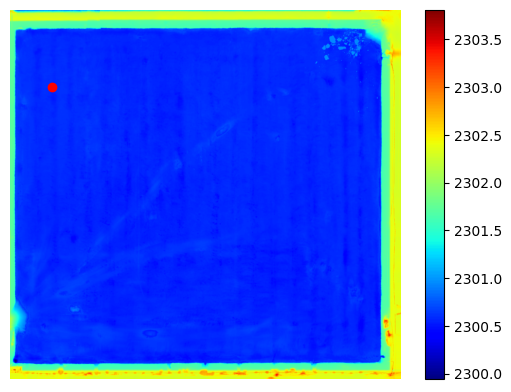

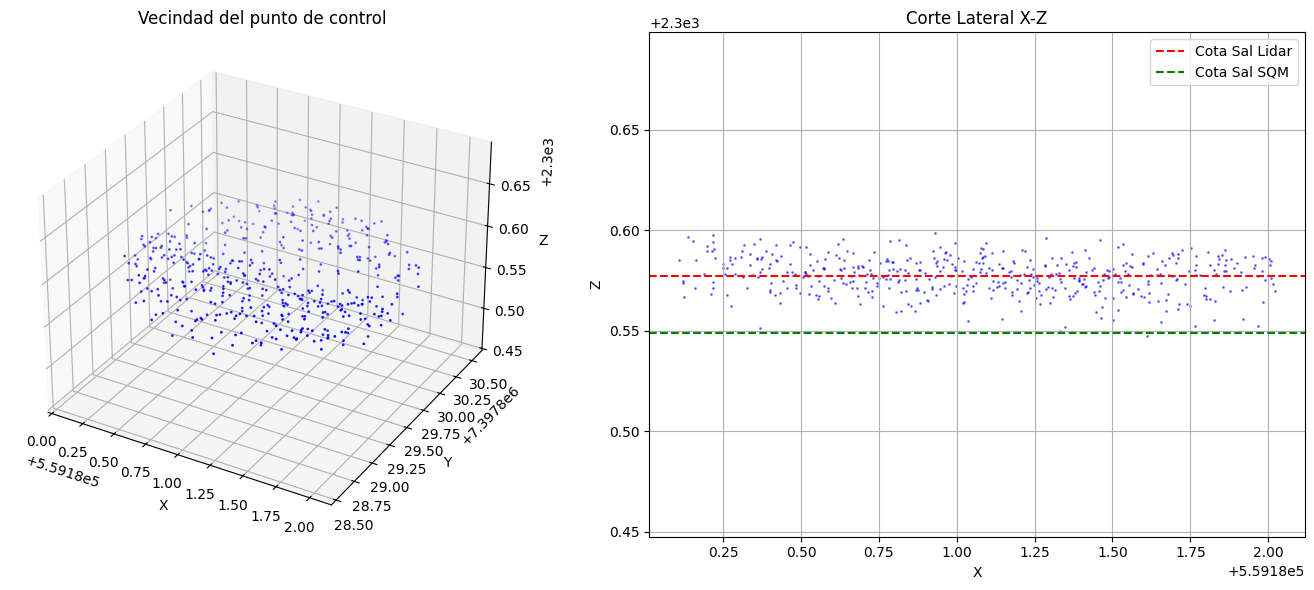

Z del punto más cercano al punto de interés: 2300.5725 Distancia: 0.05581946323565759
Cota sal promedio con error mínimo: 2300.54975 Distancia: 0.6414616124124917

Cota sal SQM: 2300.577
Cota sal promedio original: 2300.648109144543
Aplicando Nearest para NaN residuales


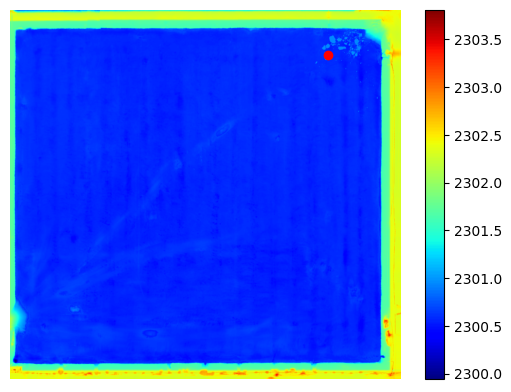

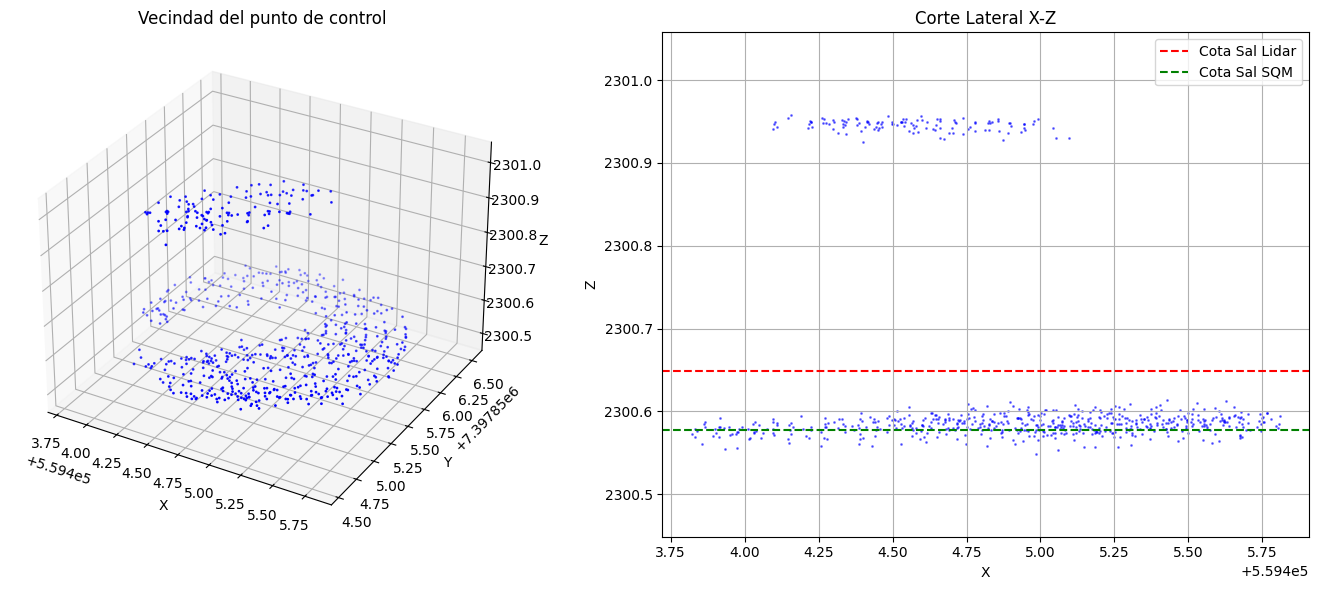

Z del punto más cercano al punto de interés: 2300.9395 Distancia: 0.0171500728564652
Cota sal promedio con error mínimo: 2300.577 Distancia: 0.6282301028312899

Cota sal SQM: 2300.549
Cota sal promedio original: 2300.5572214765098
Aplicando Nearest para NaN residuales


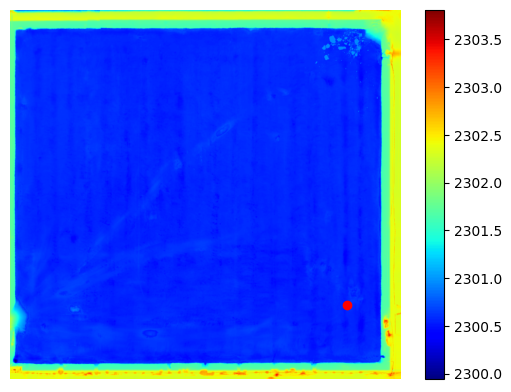

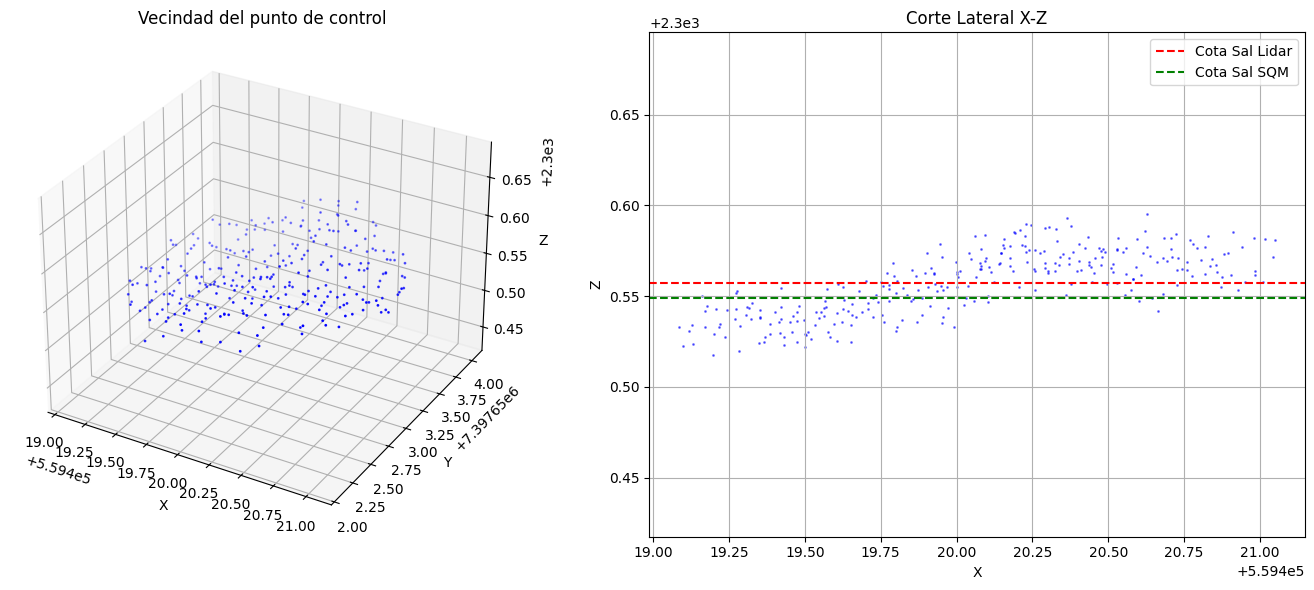

Z del punto más cercano al punto de interés: 2300.5465 Distancia: 0.044295174730926846
Cota sal promedio con error mínimo: 2300.549 Distancia: 0.45491496462742254

Cota sal SQM: 2301.48
Cota sal promedio original: nan
Z del punto más cercano al punto de interés: 2302.3385 Distancia: 27.862081115253247
Cota sal promedio con error mínimo: nan Distancia: nan

Cota sal SQM: 2301.522
Cota sal promedio original: nan
Z del punto más cercano al punto de interés: 2302.3985000000002 Distancia: 272.02059598959175
Cota sal promedio con error mínimo: nan Distancia: nan

Cota sal SQM: 2301.265
Cota sal promedio original: nan
Z del punto más cercano al punto de interés: 2302.366 Distancia: 265.9919854519388
Cota sal promedio con error mínimo: nan Distancia: nan

Cota sal SQM: 2301.331
Cota sal promedio original: nan
Z del punto más cercano al punto de interés: 2302.3627500000002 Distancia: 35.69409448318524
Cota sal promedio con error mínimo: nan Distancia: nan

Condition-LAS:  /home/diego/Downloads/

/home/diego/workspace/SQM/sqm_batimetria/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/diego/workspace/SQM/sqm_batimetria/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Cota sal SQM: 2302.237
Cota sal promedio original: nan
Z del punto más cercano al punto de interés: 2302.36475 Distancia: 7.889753564840399
Cota sal promedio con error mínimo: nan Distancia: nan

Cota sal SQM: 2300.614
Cota sal promedio original: nan
Z del punto más cercano al punto de interés: 2302.3625 Distancia: 44.62756285289168
Cota sal promedio con error mínimo: nan Distancia: nan

Cota sal SQM: 2300.549
Cota sal promedio original: nan
Z del punto más cercano al punto de interés: 2302.38325 Distancia: 239.25650771269872
Cota sal promedio con error mínimo: nan Distancia: nan

Cota sal SQM: 2300.577
Cota sal promedio original: nan
Z del punto más cercano al punto de interés: 2302.3705 Distancia: 266.1166139416816
Cota sal promedio con error mínimo: nan Distancia: nan

Cota sal SQM: 2300.549
Cota sal promedio original: nan
Z del punto más cercano al punto de interés: 2302.32875 Distancia: 63.743334322851254
Cota sal promedio con error mínimo: nan Distancia: nan

Cota sal SQM: 2301.4

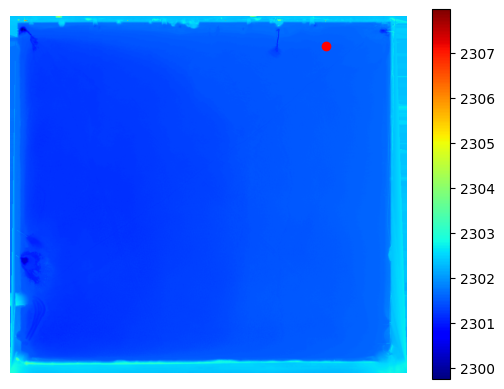

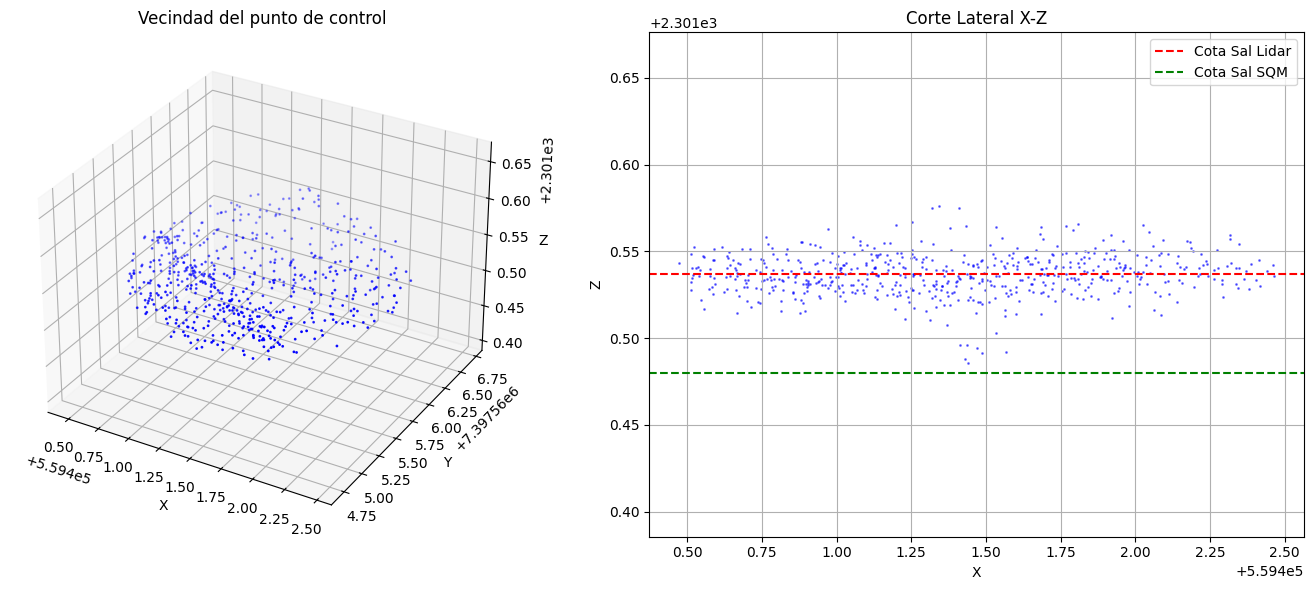

Z del punto más cercano al punto de interés: 2301.54075 Distancia: 0.03790283658656955
Cota sal promedio con error mínimo: 2301.4855 Distancia: 0.43708301625644824

Cota sal SQM: 2301.522
Cota sal promedio original: 2301.5935089285713
Aplicando Nearest para NaN residuales


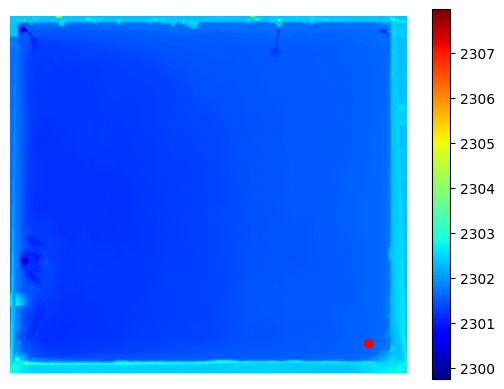

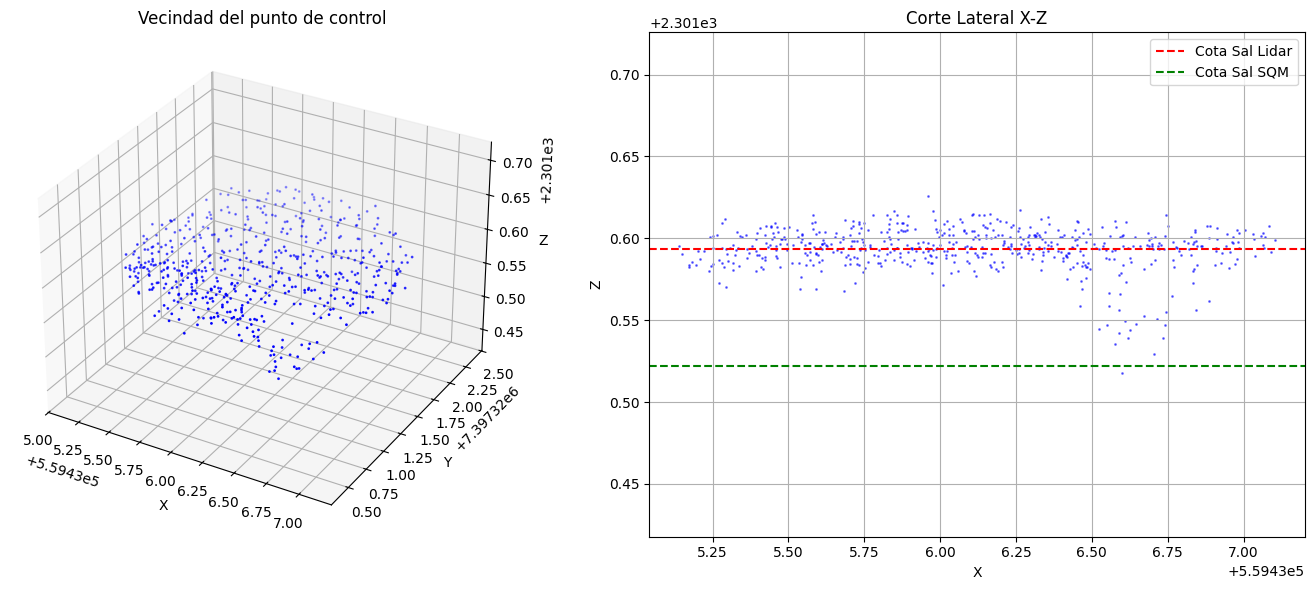

Z del punto más cercano al punto de interés: 2301.58475 Distancia: 0.018456028788076246
Cota sal promedio con error mínimo: 2301.51775 Distancia: 0.8581029223411092

Cota sal SQM: 2301.265
Cota sal promedio original: 2301.163737637363
Aplicando Nearest para NaN residuales


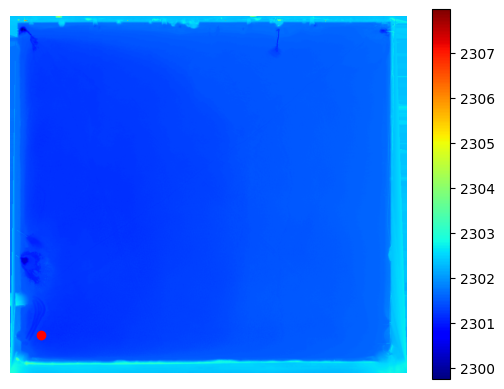

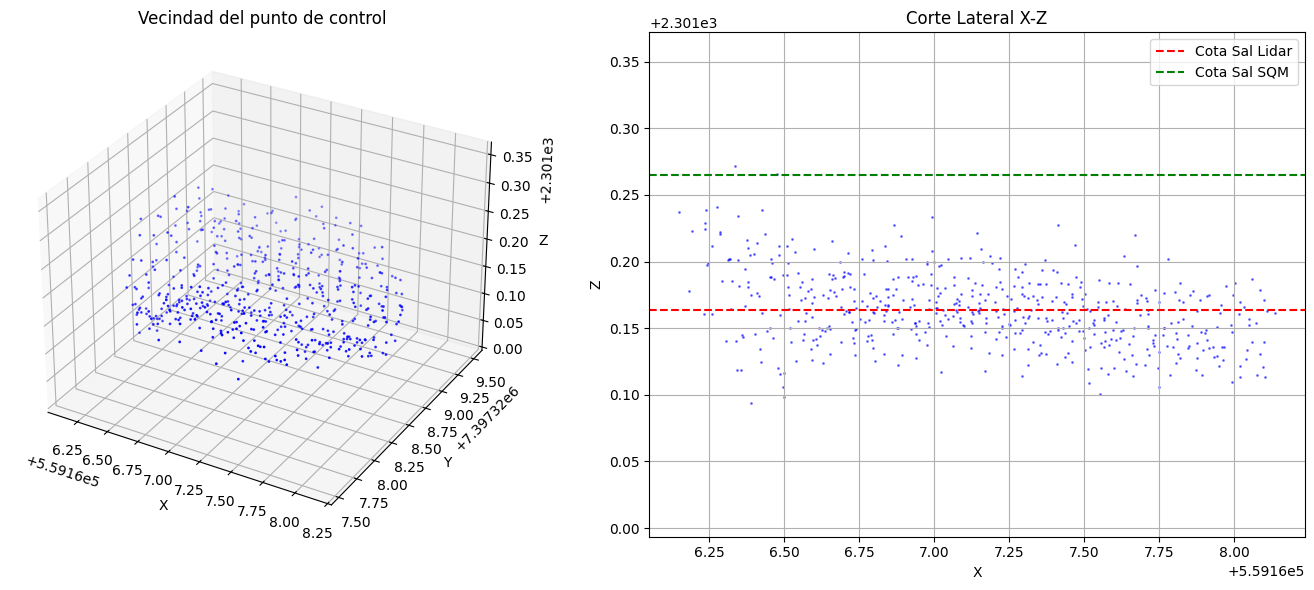

Z del punto más cercano al punto de interés: 2301.16275 Distancia: 0.012828191907454982
Cota sal promedio con error mínimo: 2301.26575 Distancia: 0.6655431053682426

Cota sal SQM: 2301.331
Cota sal promedio original: 2301.2667697889183
Aplicando Nearest para NaN residuales


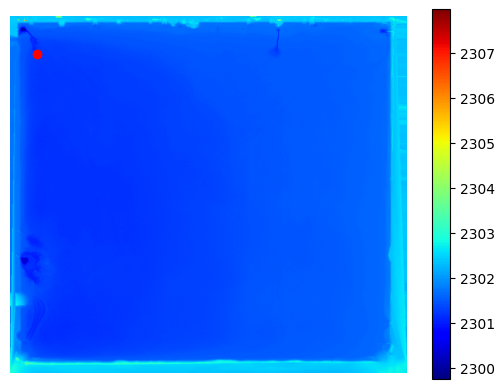

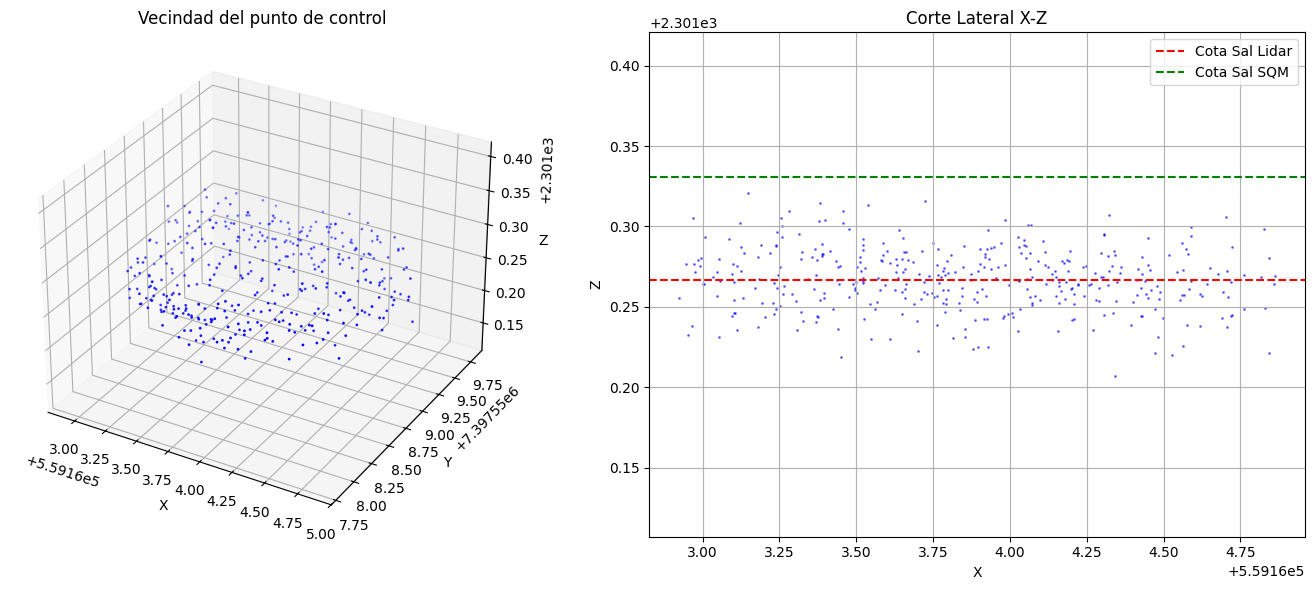

Z del punto más cercano al punto de interés: 2301.28075 Distancia: 0.04158876032960779
Cota sal promedio con error mínimo: 2301.32075 Distancia: 0.8403385106430824



In [10]:
import gc 
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import cv2

for date in dates:
    print('Date:', date)
    main_path = f"/home/diego/Downloads/data_sqm/Vuelos_{date}/*"
    CONDITION_PATHS = glob.glob(main_path)
    for cond in CONDITION_PATHS:
        print('Condition: ', cond)
        try:
            las = glob.glob(f"{cond}/*.las")
            #print(las)
        except:
            print("No existen archivos LAS para analizar")
            continue
        ## Get info
        for path in las[0:]:
            print('Condition-LAS: ', path)
            _,_,_,_,_,vuelo,condition,filename = path.split('/')
            DATE = vuelo.replace('Vuelos_',  '')
            control_points = pozas.get(DATE)

            ## Analysis
            points = get_points(path)
            #x_min, x_max, y_min, y_max = get_roi(points)
            #mask = (points[:, 0] >= x_min) & (points[:, 0] <= x_max) & \
            #(points[:, 1] >= y_min) & (points[:, 1] <= y_max)
            #roi_points = points[mask]
            roi_points = points

            del points
            gc.collect()  

            x, y, z = roi_points[:,0], roi_points[:,1], roi_points[:,2]

            points = np.vstack((x, y)).transpose()
            kdtree = KDTree(points)
            radius = 1

            for idx, (xi, yi, cota_sal_sqm) in enumerate(control_points, start=1):
                point_of_interest = np.array([xi, yi])
                indices = kdtree.query_ball_point(point_of_interest, radius)
                selected_z = z[indices]
                xa, ya = x[indices], y[indices]
                # z diffs
                diffs = np.abs(selected_z - cota_sal_sqm)
                # find the index of the minimum difference
                if len(diffs) == 0:
                    cota_sal_min_error = np.nan
                    distance = np.nan
                else:
                    min_index = np.argmin(diffs)
                    # get the corresponding z value
                    cota_sal_min_error = selected_z[min_index]
                    distance = np.linalg.norm(points[indices][min_index] - point_of_interest)
                # Clip by salt level
                #clipped_z = selected_z[selected_z >= rasante]
                cota_sal_promedio_original = np.mean(selected_z)
                #cota_sal_promedio_clipped = np.mean(clipped_z)
                #n, cota_sal = find_best_gmm(np.expand_dims(z[indices],-1), max_components=1)
                print(f'Cota sal SQM: {cota_sal_sqm}')
                print(f'Cota sal promedio original: {cota_sal_promedio_original}')
                # If cota sal promedio original is not nan
                if not math.isnan(cota_sal_promedio_original):
                    ## Create DEM
                    dem, new_xi, new_yi = generate_dem(roi_points, 0, xi, yi)  

                    ## Save DEM png OPTINAL
                    plt.imshow(dem, cmap='jet')
                    plt.plot(new_xi,new_yi,'ro') 
                    plt.colorbar()
                    plt.axis('off')
                    plt.show()

                    del dem
                    gc.collect()

                    # Configuración de la figura con dos subplots
                    fig = plt.figure(figsize=(14, 6))
                    
                    # Gráfico 3D
                    ax1 = fig.add_subplot(121, projection='3d')
                    ax1.set_zlim(selected_z.min() - 0.1, selected_z.max() + 0.1)
                    
                    ax1.scatter(xa, ya, selected_z, c='blue', s=1)
                    ax1.set_title(f'Vecindad del punto de control')
                    ax1.set_xlabel('X')
                    ax1.set_ylabel('Y')
                    ax1.set_zlabel('Z')
                    
                    # Corte lateral (X-Z)
                    ax2 = fig.add_subplot(122)
                    ax2.set_ylim(selected_z.min() - 0.1, selected_z.max() + 0.1)
                    ax2.scatter(xa, selected_z, c='blue', s=1, alpha=0.5)
                    ax2.axhline(cota_sal_promedio_original, color='red', linestyle='--', label='Cota Sal Lidar')
                    ax2.axhline(cota_sal_sqm, color='green', linestyle='--', label='Cota Sal SQM')
                    ax2.set_xlabel('X')
                    ax2.set_ylabel('Z')
                    ax2.set_title('Corte Lateral X-Z')
                    ax2.legend()
                    ax2.grid(True)

                    plt.tight_layout()
                    plt.show()

                #print(f'Cota sal promedio clipped: {cota_sal_promedio_clipped}')

                # find the nearest point to the point of interest
                nearest_index = kdtree.query(point_of_interest)[1]
                nearest_point = points[nearest_index]
                nearest_z = z[nearest_index]
                min_distance = np.linalg.norm(nearest_point - point_of_interest)
                #print(f'Nearest point: {nearest_point}')
                print(f'Z del punto más cercano al punto de interés: {nearest_z}', f'Distancia: {min_distance}')
                print(f'Cota sal promedio con error mínimo: {cota_sal_min_error}', f'Distancia: {distance}')
                print("")
    break